In [1]:
%cd ..

/home/akajal/DiVAE


In [2]:
# Python imports
import os
import sys

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# ML imports
import torch
import matplotlib.pyplot as plt
import numpy as np
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf

# DiVAE imports
from models.rbm.chimeraRBM import ChimeraRBM
from models.rbm.qimeraRBM import QimeraRBM
from models.rbm.rbm import RBM
from models.samplers.pcd import PCD
from models.autoencoders.gumboltCaloCRBM import GumBoltCaloCRBM

from nbutils import *

# DWave imports
from dwave.system import DWaveSampler, LeapHybridSampler
import neal

[11:17:57.567] INFO   DiVAE                                             Willkommen!
[11:17:57.568] INFO   DiVAE                                             Loading configuration.
2022-09-12 11:17:58,337 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[11:17:58.337] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [3]:
ZERO = torch.tensor(0., dtype=torch.float)
MINUS_ONE = torch.tensor(-1., dtype=torch.float)

In [4]:
def init_model(cfg):
    model = GumBoltCaloCRBM(flat_input_size=[504],
                            train_ds_mean=0.,
                            activation_fct=torch.nn.ReLU(),
                            cfg=cfg)
    return model

In [5]:
with initialize(config_path="../configs"):
    cfg = compose(config_name="config")

/opt/conda/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [6]:
model = init_model(cfg)
model.create_networks()

2022-09-12 11:26:00,426 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[11:26:00.426] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-09-12 11:26:00,531 dwave.cloud.client.base INFO  MainThread Requested a solver that best matches feature filters={}
[11:26:00.531] INFO   dwave.cloud.client.base                           Requested a solver that best matches feature filters={}
2022-09-12 11:26:00,535 dwave.cloud.client.base INFO  MainThread Fetching solvers according to filters={'topology__type': 'chimera', 'chip_id': 

Initializing NetworkV3


In [7]:
run_path = '/home/akajal/DiVAE/outputs/2022-03-11/15-21-04/wandb/run-20220311_152104-2junzvyl/files/GumBoltCaloCRBM_calo_default_latest.pth'
load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))

Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
Loading weights for module =  sampler


In [8]:
qpu_sampler = DWaveSampler(solver={"topology__type":"chimera", "chip_id":"DW_2000Q_6"})

aux_crbm = QimeraRBM(n_visible=model.prior._n_visible, n_hidden=model.prior._n_hidden)
aux_crbm_sampler = PCD(batch_size=1024, RBM=aux_crbm, n_gibbs_sampling_steps=100)

2022-09-12 11:27:06,847 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[11:27:06.847] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-09-12 11:27:07,003 dwave.cloud.client.base INFO  MainThread Requested a solver that best matches feature filters={}
[11:27:07.003] INFO   dwave.cloud.client.base                           Requested a solver that best matches feature filters={}
2022-09-12 11:27:07,006 dwave.cloud.client.base INFO  MainThread Fetching solvers according to filters={'topology__type': 'chimera', 'chip_id': 

In [12]:
def beta_fixed_qpu(num_iterations:int=10, lr:float=0.01, beta_init=10., n_reads:int=100, qpu_sampler=None, aux_crbm_sampler=None):
    """Estimate the temperature associated with a given QPU configuration
    
    :param num_iterations (int) : Number of iterations
    :param lr (float) : Learning rate
    :param beta_init (float) : Initial estimate of the QPU temperature
    :param n_qpu_samples (int) : Number of QPU samples
    :param qpu_sampler
    
    """
    assert qpu_sampler is not None
    assert aux_crbm_sampler is not None
    
    beta = beta_init
    betas = [beta]
    
    # Auxiliary scaled RBM
    aux_crbm = aux_crbm_sampler.rbm
    aux_crbm_edgelist = aux_crbm.pruned_edge_list
    
    # Setup QPU control variables
    n_vis = len(aux_crbm.visible_qubit_idxs)
    n_hid = len(aux_crbm.visible_qubit_idxs)
    qubit_idxs = aux_crbm.visible_qubit_idxs+aux_crbm.hidden_qubit_idxs
    
    visible_idx_map = {visible_qubit_idx:i for i, visible_qubit_idx in enumerate(aux_crbm.visible_qubit_idxs)}
    hidden_idx_map = {hidden_qubit_idx:i for i, hidden_qubit_idx in enumerate(aux_crbm.hidden_qubit_idxs)}
        
    ising_weights = torch.nn.Parameter(-2*torch.rand(n_vis, n_hid) + 1.5, requires_grad=False)
    #ising_weights = torch.nn.Parameter(-2*torch.rand(n_vis, n_hid) + 0.5, requires_grad=False)
    ising_vbias = torch.nn.Parameter(torch.zeros(n_vis), requires_grad=False)
    ising_hbias = torch.nn.Parameter(torch.zeros(n_hid), requires_grad=False)
    
    dwave_weights_np = -ising_weights.detach().cpu().numpy()
    print("J range = ({0}, {1})".format(np.min(dwave_weights_np),
                                        np.max(dwave_weights_np)))
    
    h = {qubit_idx:0. for qubit_idx in qubit_idxs}
    J = {}
    for edge in aux_crbm_edgelist:
        if edge[0] in aux_crbm.visible_qubit_idxs:
            J[edge] = dwave_weights_np[visible_idx_map[edge[0]]][hidden_idx_map[edge[1]]]
        else:
            J[edge] = dwave_weights_np[visible_idx_map[edge[1]]][hidden_idx_map[edge[0]]]
                
    response = qpu_sampler.sample_ising(h, J, num_reads=n_reads, auto_scale=False)
    dwave_samples, dwave_energies = batch_dwave_samples(response)
    dwave_samples = torch.tensor(dwave_samples, dtype=torch.float)
    dwave_vis, dwave_hid = dwave_samples[:, :n_vis], dwave_samples[:, n_vis:]
        
    dwave_energy_exp = ising_energies_exp(ising_weights, ising_vbias, ising_hbias, dwave_vis, dwave_hid)
    dwave_energy_exp = torch.mean(dwave_energy_exp, axis=0)
    print("dwave_energy_exp : {0}".format(dwave_energy_exp))
    
    aux_crbm._visible_bias = ising_vbias
    aux_crbm._hidden_bias = ising_hbias
    
    aux_crbm_weights = 4.*ising_weights
    
    for i in range(num_iterations):
        # Calculate the rescaled parameters of the auxiliary RBM
        aux_crbm.weights = (aux_crbm_weights*aux_crbm.weights_mask)/beta
        aux_crbm_sampler.rbm = aux_crbm
        
        aux_crbm_vis, aux_crbm_hid = aux_crbm_sampler.block_gibbs_sampling()
        
        aux_crbm_vis = torch.where(aux_crbm_vis == ZERO, MINUS_ONE, aux_crbm_vis)
        aux_crbm_hid = torch.where(aux_crbm_hid == ZERO, MINUS_ONE, aux_crbm_hid)
        
        aux_crbm_energy_exp = ising_energies_exp(ising_weights, ising_vbias, ising_hbias, aux_crbm_vis, aux_crbm_hid)
        aux_crbm_energy_exp = torch.mean(aux_crbm_energy_exp, axis=0)
        
        print("aux_crbm_energy_exp : {0}, beta : {1}".format(aux_crbm_energy_exp, beta))
        beta = beta - lr*(-float(aux_crbm_energy_exp)+float(dwave_energy_exp))
        betas.append(beta)
        
    return betas

In [14]:
betas = beta_fixed_qpu(num_iterations=10,
                       lr=0.00001,
                       beta_init=4.,
                       n_reads=100,
                       qpu_sampler=qpu_sampler,
                       aux_crbm_sampler=aux_crbm_sampler)

J range = (-1.4999982118606567, 0.4999946355819702)
dwave_energy_exp : 246078.296875
aux_crbm_energy_exp : 303430.09375, beta : 4.0
aux_crbm_energy_exp : 266518.25, beta : 4.57351796875
aux_crbm_energy_exp : 254689.953125, beta : 4.7779175
aux_crbm_energy_exp : 249326.578125, beta : 4.8640340625
aux_crbm_energy_exp : 247602.703125, beta : 4.896516875
aux_crbm_energy_exp : 246687.25, beta : 4.9117609374999995
aux_crbm_energy_exp : 246157.890625, beta : 4.917850468749999
aux_crbm_energy_exp : 246158.828125, beta : 4.91864640625
aux_crbm_energy_exp : 246066.609375, beta : 4.9194517187499995
aux_crbm_energy_exp : 246262.296875, beta : 4.91933484375


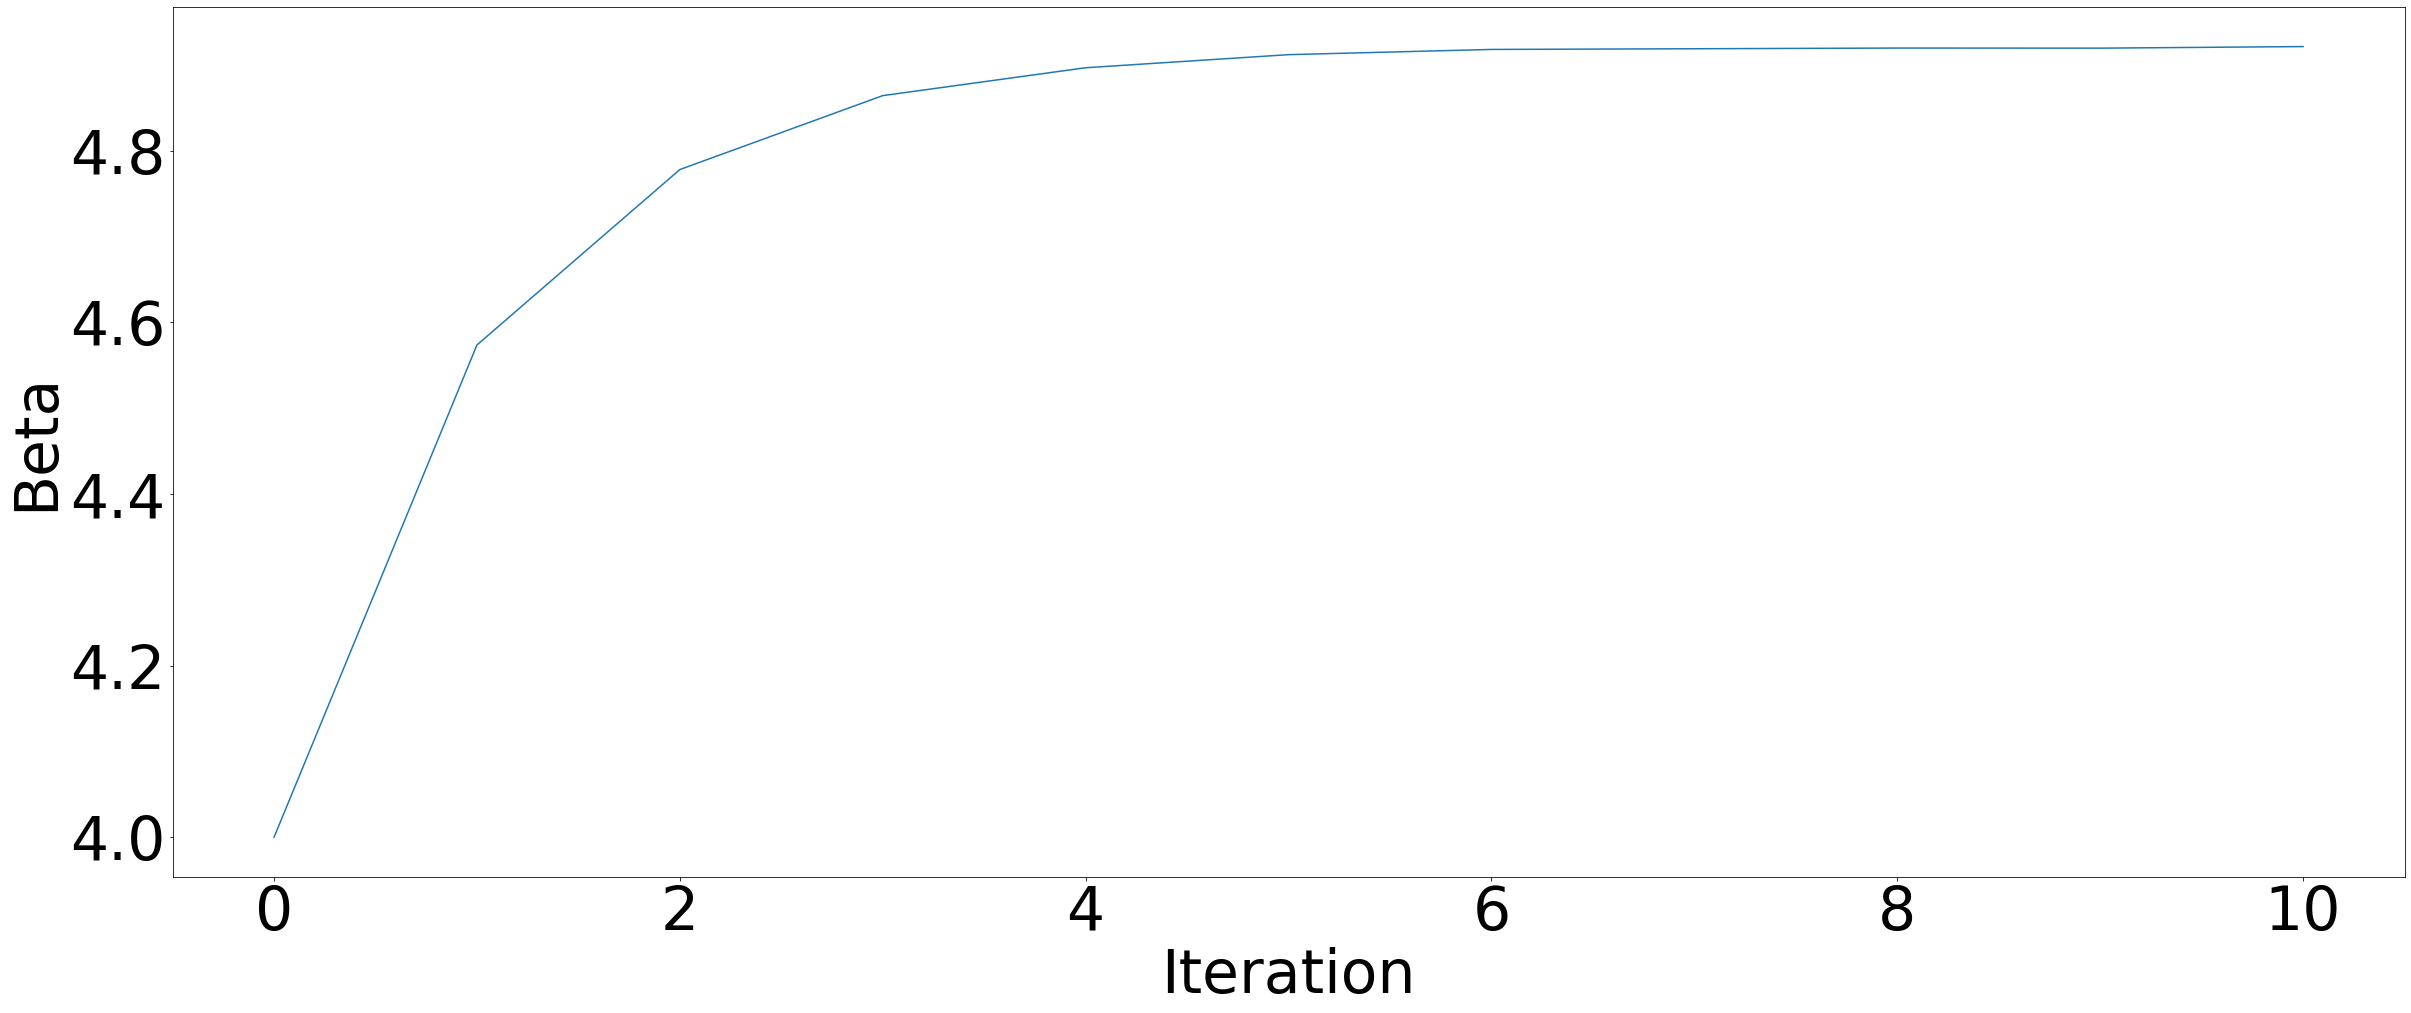

In [15]:
plot_betas(betas)